<a href="https://colab.research.google.com/github/valedalama/farmos/blob/main/farmOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Farm record-keeping in farmOS via OpenAPI Is it feasible?
_exploring the possibilities, and the constraints_

## Farm Record-Keeping Context
The following Use Case Diagram illustrates the flow of data related to this farm operation:

![Use Case Diagram](https://trello-attachments.s3.amazonaws.com/59f1fb4bb19910c6c6a4367f/5d525f2e59b77812de3869d8/60ac32f649e3afd58602f41d0682bf2b/Farm_Data_Processing.jpeg)

... which is probably fairly typical of most farm record keeping dataflows, in essence.  The UseCase we aim to address in this iteration is based on the following User Story (from the actor depicted in LL of above diagram):

-   **"In my Role as PM:OMG (Production Manager for the Organic Market Garden), the harvest data that i gather 2x /week from the OMG team in spreadsheet form needs to be uploaded to farmOS on a weekly basis with as little friction as possible."**


## Focus ;  Research Question(s)
This UseCase, and some of the complications about it is further elaborated in [this thread from farmOS Discourse forum](https://farmos.discourse.group/t/csv-importers-in-v2-x/942) ; the essence of the problem lies in these two facts: 

* Crop Plan and Harvest Log data is being collected in spreadsheets; and
* There is at present no "Import CSV" feature in v2 of farmOS.

therefore- until there is an "Import CSV" facility developed for farmOS v2.x- such data collected in spreadsheets can only be uploaded via API.

**QUESTION(S) for Research:**
1. Is it feasible to deploy a tool for API access to farm staff, in a form that is usable enough to fit into weekly farm workflow?
1. Is it possible to upload files of both Crop Plan (i.e. "Plant asset") and Harvest Log type via API, such that both POST of new records and PUT (update) on existing records is done in a way that is transparent to the user?
1. Database Referential Integrity: Is it possible via the "Name" field that identifies Plant assets uniquely, to maintain links between Harvest logs and the Plant asset to which they pertain?

# CSV Data Collection + Preliminary EDA

In [2]:
# import needed libraries, and check versions
import numpy as np
import pandas as pd   #load the software
print("Pandas version ",pd.__version__)  # confirm software version, to guarantee reproducible results
print("Numpy version ",np.__version__)

Pandas version  1.3.5
Numpy version  1.21.5


In [4]:
# Import the .csv datafile of Plant assets (crops) and eyeball a few
df=pd.read_csv("/content/CROPS.csv")
# do hi-level overview
print("Number of Rows, Columns = ",df.shape)  #to know the depth & scope of dataframe
print("Column Headers: ",df.columns)  # to see names of column headers
print("Datatype of index = ",type(df.index[0]))  # to confirm datatype of the index

Number of Rows, Columns =  (213, 8)
Column Headers:  Index(['Name', 'Archived', 'Description', 'Parent IDs', 'Parent names',
       'Crop/variety', 'Season', 'Area/Location'],
      dtype='object')
Datatype of index =  <class 'int'>


In [5]:
df.head()

,Name,Archived,Description,Parent IDs,Parent names,Crop/variety,Season,Area/Location
0,2021-W20 Carrot HVE01,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 1
1,2021-W50 Lettuce HVE01-N,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Lettuce,WINTER,HortasDoVale-East (HDVE) - bed 1 north section
2,2021-W22 Carrot HVE02,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 2
3,2021-W38 Carrot HVE03,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Carrot,AUTUMN,HortasDoVale-East (HDVE) - bed 3
4,2021-W24 Sweet potato HVE04-N,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Sweet potato,SUMMER,HortasDoVale-East (HDVE) - bed 4 north section


In [ ]:
# for a more agile/ interactive view of the Pandas dataframe, load gColab's "Interactive Data Table" extension
%load_ext google.colab.data_table
df

,Name,Archived,Description,Parent IDs,Parent names,Crop/variety,Season,Area/Location
0,2021-W20 Carrot HVE01,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 1
1,2021-W50 Lettuce HVE01-N,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Lettuce,WINTER,HortasDoVale-East (HDVE) - bed 1 north section
2,2021-W22 Carrot HVE02,NaN,Length (m): 55.2; Nr of plants: 11040,NaN,NaN,Carrot,SPRING,HortasDoVale-East (HDVE) - bed 2
3,2021-W38 Carrot HVE03,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Carrot,AUTUMN,HortasDoVale-East (HDVE) - bed 3
4,2021-W24 Sweet potato HVE04-N,NaN,Length (m): 27.6; Nr of plants: 27,NaN,NaN,Sweet potato,SUMMER,HortasDoVale-East (HDVE) - bed 4 north section
...,...,...,...,...,...,...,...,...
208,2021-W14 Tomato small WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Tomato small,SPRING,Winter Green House - bed 6
209,2021-W14 Tomato roma WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Tomato roma,SPRING,Winter Green House - bed 6
210,2021-W47 Salanova WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Salanova,AUTUMN,Winter Green House - bed 6
211,2021-W47 Lettuce WGH06,NaN,Length (m): ; Nr of plants:,NaN,NaN,Lettuce,AUTUMN,Winter Green House - bed 6


## Exploring the data frame
NB:  This "Interactive Data Table" extension brings useful functionality- see how you can Sort on any column, set any combination of Filters, adjust Pagination, etc. -but such functions may not accompany this .ipynb file to its deployment in other tools in the Jupyter ecosystem.

## Visualizing the data

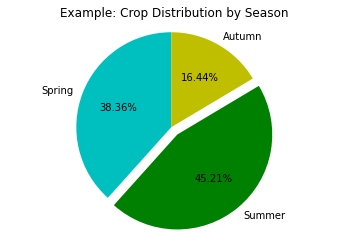

In [ ]:
# start with a simple pie-chart of crop distribution by season, based on this pie-chart example
import matplotlib.pyplot as plt

labels = 'Spring', 'Summer', 'Autumn'
sections = [56, 66, 24]
colors = ['c', 'g', 'y']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        explode = (0, 0.1, 0),
        autopct = '%1.2f%%')

plt.axis('equal') # Try commenting this out.
plt.title('Example: Crop Distribution by Season')
plt.show()

# Test the API for essential interactions
Essential operations to test, in order:
1. Obtain credentials to interact with API
1. GET whatever data we need, before we proceed to
1. PUT updates to existing records, or POST new data.

In [ ]:
!pip install farmOS==1.0.0b3

     |████████████████████████████████| 10.9 MB 7.9 MB/s 


## API Access: grant of credentials

As a precondition of access, it is necessary to get an OAuth token from the server; this token must be periodically refreshed according to some present parameter....

Moreover: to protect integrity of the database, it is important that credentials be sent across the wire in secure fasion...

In [ ]:
from farmOS import farmOS #load the library
farm_client = farmOS(hostname="https://vdl.farmos.dev", client_id="farm", scope="farm_manager") #login
current_token = farm_client.authorize(username="apiTest", password="api+35+erAPI") #get OAuth token
farm_client.info() #poll API for endpoints

{'data': [],
 'jsonapi': {'meta': {'links': {'self': {'href': 'http://jsonapi.org/format/1.0/'}}},
  'version': '1.0'},
 'links': {'asset--animal': {'href': 'https://vdl.farmos.dev/api/asset/animal'},
  'asset--equipment': {'href': 'https://vdl.farmos.dev/api/asset/equipment'},
  'asset--group': {'href': 'https://vdl.farmos.dev/api/asset/group'},
  'asset--land': {'href': 'https://vdl.farmos.dev/api/asset/land'},
  'asset--plant': {'href': 'https://vdl.farmos.dev/api/asset/plant'},
  'asset--sensor': {'href': 'https://vdl.farmos.dev/api/asset/sensor'},
  'asset--structure': {'href': 'https://vdl.farmos.dev/api/asset/structure'},
  'asset_type--asset_type': {'href': 'https://vdl.farmos.dev/api/asset_type/asset_type'},
  'data_stream--basic': {'href': 'https://vdl.farmos.dev/api/data_stream/basic'},
  'data_stream_type--data_stream_type': {'href': 'https://vdl.farmos.dev/api/data_stream_type/data_stream_type'},
  'entity_browser--entity_browser': {'href': 'https://vdl.farmos.dev/api/enti

## Test GET functionality

In [ ]:
# logs = list(farm_client.log.iterate('harvest'))
harvest = farm_client.log.get('harvest')
harvest

{'data': [{'attributes': {'changed': '2021-10-11T07:13:44+00:00',
    'created': '2019-05-12T14:29:08+00:00',
    'data': None,
    'default_langcode': True,
    'drupal_internal__id': 15,
    'drupal_internal__revision_id': 507,
    'flag': ['review'],
    'geometry': None,
    'is_group_assignment': False,
    'is_movement': False,
    'langcode': 'en',
    'lot_number': None,
    'name': 'Lowlands Haying operation',
    'notes': {'format': 'default',
     'processed': '<p>Forecast haying time will be in June -and, as agreed, João gets first cut, for silage</p>\n',
     'value': 'Forecast haying time will be in June -and, as agreed, João gets first cut, for silage'},
    'revision_created': '2022-01-12T16:12:11+00:00',
    'revision_log_message': None,
    'revision_translation_affected': None,
    'status': 'done',
    'timestamp': '2019-06-01T14:29:08+00:00'},
   'id': '9abea96a-852d-4198-b967-19ae9e443e44',
   'links': {'self': {'href': 'https://vdl.farmos.dev/api/log/harvest/9abe

In [ ]:
# crops = list(farm_client.asset.iterate('plant'))
crops = farm_client.asset.get('plant')
crops

{'data': [{'attributes': {'archived': '2021-10-11T08:33:52+00:00',
    'changed': '2021-10-11T08:33:52+00:00',
    'created': '2019-05-10T13:57:41+00:00',
    'data': None,
    'default_langcode': True,
    'drupal_internal__id': 1,
    'drupal_internal__revision_id': 751,
    'flag': ['review'],
    'geometry': None,
    'id_tag': [],
    'intrinsic_geometry': None,
    'is_fixed': False,
    'is_location': False,
    'langcode': 'en',
    'name': 'CarobOrchard trees',
    'notes': None,
    'revision_created': '2021-10-11T14:15:27+00:00',
    'revision_log_message': None,
    'revision_translation_affected': None,
    'status': 'archived'},
   'id': '71d92c3b-1dd7-4d47-b684-a50ed8561b7d',
   'links': {'self': {'href': 'https://vdl.farmos.dev/api/asset/plant/71d92c3b-1dd7-4d47-b684-a50ed8561b7d'}},
   'relationships': {'asset_type': {'data': {'id': '6e931f20-d90a-4bbc-be61-d129520c10e5',
      'meta': {'drupal_internal__target_id': 'plant'},
      'type': 'asset_type--asset_type'},
  

## Test PUT functionality

This is the tricky bit: to be able to upload CSV files such that existing records will be updated (i.e. a PUT call) and only new records will be POSTed, such that no duplicate records are created. 

Moreover: w/r/t Harvest logs need always to refer to the Plant asset on which they are acting- and not just once; most Plant assets will support many Harvest events- so that the related files can be pulled in a single query.

# Test the Interface for Usability
To create a sustainable data workflow, it is important that the staff be able to perform key functions with relative ease, including:
1. Upload Plant asset CSV (an occasional operation)
1. Upload Harvest log CSV (weekly operation)
1. Access desired information about plantations and harvests
...